In [1]:
%matplotlib inline  
import os
import numpy as np
import pandas as pd
import tempfile
import random
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib.pyplot as plt


C:\Users\30678\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def IEEE13_single_phase_net():
    voltage= 500 #va_kv
    n= 13
    distanceMu= 10
    distanceSigma= 2
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)
    bs= {i: pp.create_bus(net, voltage) for i in range(n)}

    pp.create_line(net, bs[0], bs[1], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[1], bs[4], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[1], bs[2], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[1], bs[6], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[2], bs[3], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[4], bs[5], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[6], bs[9], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[6], bs[7], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[6], bs[11],np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[7], bs[8], np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[9], bs[10],np.random.normal(distanceMu, distanceSigma, 1), "184-AL1/30-ST1A 20.0")
    pp.create_line(net, bs[9], bs[12],np.random.normal(distanceMu, distanceSigma, 1),"184-AL1/30-ST1A 20.0")

    for i in range(n):
        pp.create_load(net, bs[i], p_mw=15., q_mvar=10., name=f'load{i}')
    pp.create_gen(net, bs[0], vm_pu=1.02, p_mw=1000, name='Gas turbine', slack=True)
    return net

In [3]:
def create_load_samples(mu, sigma, timeStep= 10, n= 13):
    profiles = pd.DataFrame()
    for i in range(n):
        profiles[f'load{i}'] = np.random.normal(mu, sigma, timeStep)
    ds = DFData(profiles)
    return profiles, ds

def create_controllers(net, ds, n):
    ConstControl(net, element='load', variable='p_mw', element_index=[i for i in range(n)],
                 data_source=ds, profile_name=[f"load{i}" for i in range(n)])

def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_load', 'q_mvar')
    ow.log_variable('res_bus', 'va_degree')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

def plot_matrix(matrix):
    # Plotting the covariance matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar()
    plt.title('Matrix')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.grid(False)  # Turn off the grid lines if they are not needed
    plt.show()

In [4]:
net = IEEE13_single_phase_net()
timesteps = 1000
profiles, ds = create_load_samples(15, 1, timesteps, 13)
create_controllers(net, ds, 13)
time_steps = range(0, timesteps)
output_dir = "time_series"
ow = create_output_writer(net, time_steps, output_dir=output_dir)
run_timeseries(net, time_steps)
#print(net.res_line.loading_percent)

c:\Users\30678\.conda\envs\tf\lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 1000)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\30678\.conda\envs\tf\lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 1000/1000 [00:07<00:00, 141.98it/s]


In [273]:
(net.res_line.p_from_mw[2])/(net.res_line.vm_from_pu[2]-net.res_line.vm_to_pu[2])


104766.69927938431

In [249]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,175.644869,17.189840,-175.473263,-24.793421,0.171606,-7.603582,0.199790,0.200861,0.200861,1.020000,0.000000,1.018771,-0.109381,37.544169
1,27.980072,4.331978,-27.974610,-13.485910,0.005463,-9.153932,0.032091,0.035210,0.035210,1.018771,-0.109381,1.018469,-0.127482,6.581231
2,27.293202,0.976524,-27.288136,-10.394903,0.005065,-9.418379,0.030955,0.033106,0.033106,1.018771,-0.109381,1.018510,-0.128667,6.187958
3,106.513640,9.484920,-106.435125,-19.147381,0.078515,-9.662461,0.121203,0.122687,0.122687,1.018771,-0.109381,1.017825,-0.190973,22.932094
4,13.770036,0.394903,-13.768596,-10.000000,0.001440,-9.605097,0.015618,0.019295,0.019295,1.018510,-0.128667,1.018343,-0.137703,3.606628
5,14.103534,3.485910,-14.102432,-10.000000,0.001102,-6.514090,0.016471,0.019603,0.019603,1.018469,-0.127482,1.018340,-0.133393,3.664125
6,45.177759,6.195153,-45.166276,-13.897539,0.011483,-7.702386,0.051733,0.053630,0.053630,1.017825,-0.190973,1.017463,-0.217038,10.024305
7,30.656375,-0.096758,-30.649228,-10.540719,0.007147,-10.637478,0.034779,0.036781,0.036781,1.017825,-0.190973,1.017512,-0.216031,6.874964
8,14.529712,3.048987,-14.528488,-10.000000,0.001224,-6.951013,0.016843,0.020012,0.020012,1.017825,-0.190973,1.017686,-0.197604,3.740551
9,15.578620,0.540719,-15.576843,-10.000000,0.001778,-9.459281,0.017690,0.021010,0.021010,1.017512,-0.216031,1.017334,-0.226369,3.927082


-1.883846112518574e+99


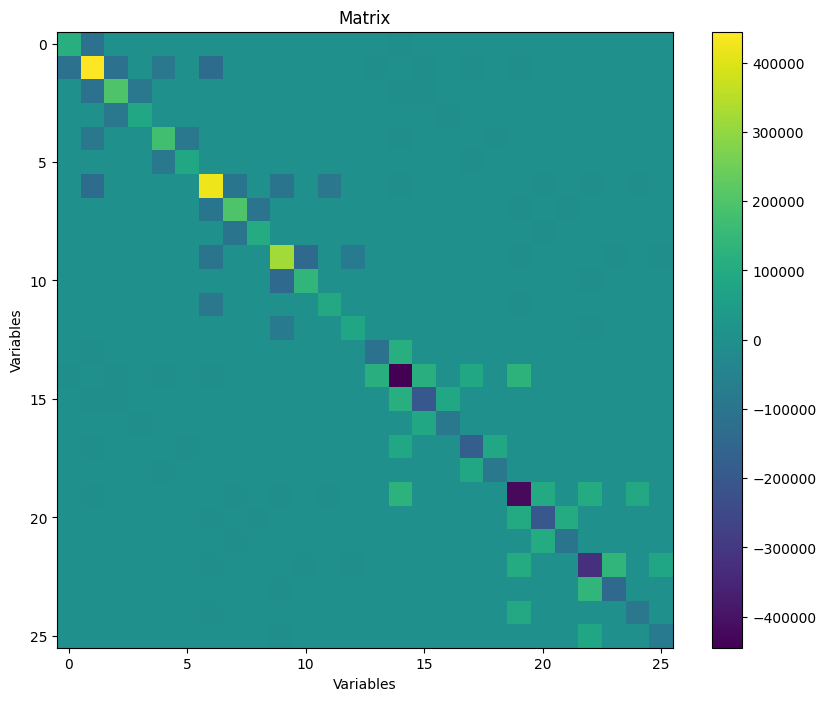

In [5]:
n= 13
link2idx={0:(0, 1), 1:(1, 4), 2: (1, 2), 3: (1, 6), 4:(2, 3), 5:(4, 5), 6:(6,9), 7:(6,7), 8:(6,11), 9:(7, 8), 10:(9, 10), 11:(9, 12)}
rs= (net.line.length_km*net.line.r_ohm_per_km).to_numpy()
xs= (net.line.length_km*net.line.x_ohm_per_km-1/(net.line.length_km*net.line.c_nf_per_km)).to_numpy()
gs= ((net.res_line.p_from_mw)/(net.res_line.vm_from_pu-net.res_line.vm_to_pu)).to_numpy()
bs= ((net.res_line.q_from_mvar)/(net.res_line.va_from_degree-net.res_line.va_to_degree)).to_numpy()
def create_laplacian(link2idx, gORb, n):
    A= np.zeros((n, n))
    for i in link2idx:
        x, y = link2idx[i]
        A[x, y]= -gORb[i]
        A[y, x]= -gORb[i]
    DiagValue= -A.sum(axis= 1)
    for i in link2idx:
        x, y = link2idx[i]
        A[y, x]= -gORb[i]
    for i in range(n):
        A[i, i]= DiagValue[i]
    return A
Hg= create_laplacian(link2idx, gs, n)
Hb= create_laplacian(link2idx, bs, n)
H= np.zeros((2*n, 2*n))
H[0:n, 0:n]= Hg
H[0:n, n:]= Hb
H[n:, 0:n]= Hb
H[n:, n:]= -Hg
# Hinv= np.linalg.inv(Hg)
print(np.linalg.det(H))
plot_matrix(H)

In [272]:
vm_np= vm_pu.to_numpy() #(1000, 13)
va_degree_np= va_degree.to_numpy()/180*np.pi
vComplex= np.concatenate((vm_np, va_degree_np), axis= 1)
p_mw_np= load.to_numpy()*1e6
q_mvar_np= q_mvar.to_numpy()*1e6
pComplex= np.concatenate((p_mw_np, q_mvar_np), axis= 1)
print(vComplex.shape)
print(rs[0])

(1000, 26)
1.4260507847784114


In [265]:
(vComplex[1][0]-vComplex[1][1])*gs[0]

86217460.34898496

In [266]:
print((vComplex[1][1]-vComplex[1][6])*gs[3])
print((vComplex[1][6]-vComplex[1][9])*gs[6])
print((vComplex[1][6]-vComplex[1][7])*gs[7])
print((vComplex[1][6]-vComplex[1][11])*gs[8])

47096813.19865411
30071010.69801737
10308955.302888282
8090377.594876039


In [271]:
print(H.dot(vComplex[1]))

print(pComplex[1])

[ 1.89174602e+02 -3.57031483e+01 -7.22475153e+00 -1.53077415e+01
 -3.60762535e-01 -2.83886206e+01  6.24541286e+00 -4.52302426e+00
 -1.60337552e+01 -3.70175712e+01 -1.52152717e+01 -1.98665141e+01
 -1.57788536e+01 -1.52206877e+04  3.96757392e+03  6.71693143e+02
  8.70643711e+02  6.27316363e+02  1.33851935e+03  1.21885877e+03
  6.54855130e+02  8.95089671e+02  2.74821510e+03  7.08106631e+02
  8.40214300e+02  6.79601633e+02]
[16629569.76003336 13307043.11722173 14336990.26691266 15389621.43736834
 14170112.78387202 15790454.47589098 13924174.32280437 14810552.68590611
 13820405.60539855 13517423.88488416 16596212.95160566 15213041.06153338
 14887124.58767467 10000000.         10000000.         10000000.
 10000000.         10000000.         10000000.         10000000.
 10000000.         10000000.         10000000.         10000000.
 10000000.         10000000.        ]


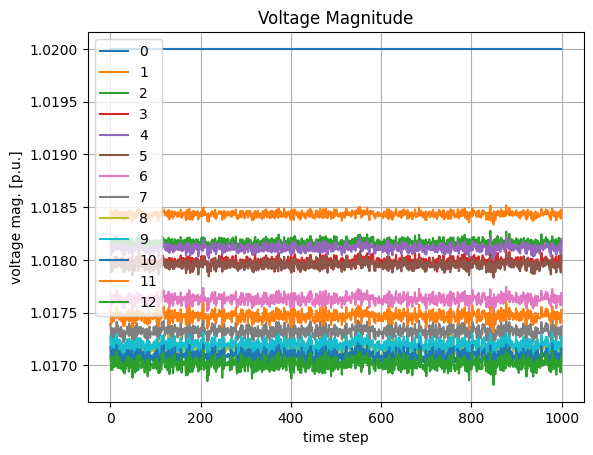

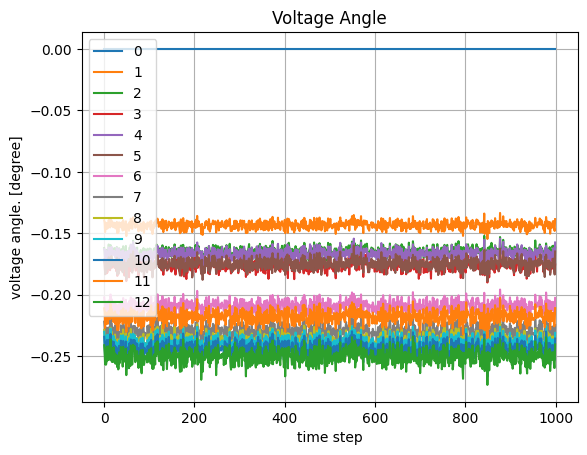

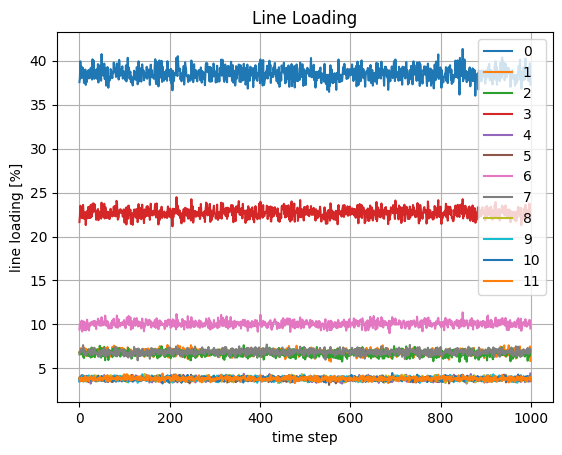

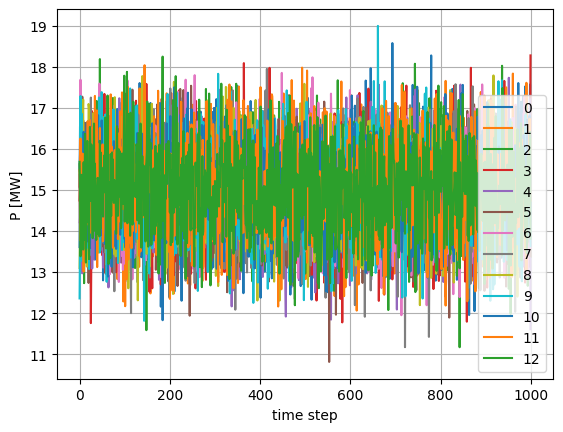

In [6]:


# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# voltage results
va_degree_file = os.path.join(output_dir, "res_bus", "va_degree.xlsx")
va_degree = pd.read_excel(va_degree_file, index_col=0)
va_degree.plot(label="va_degree")
plt.xlabel("time step")
plt.ylabel("voltage angle. [degree]")
plt.title("Voltage Angle")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

# q load results
q_mvar_file = os.path.join(output_dir, "res_load", "q_mvar.xlsx")
q_mvar = pd.read_excel(q_mvar_file, index_col=0)

(1000, 13)
(1000, 13)


C:\Users\30678\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\30678\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


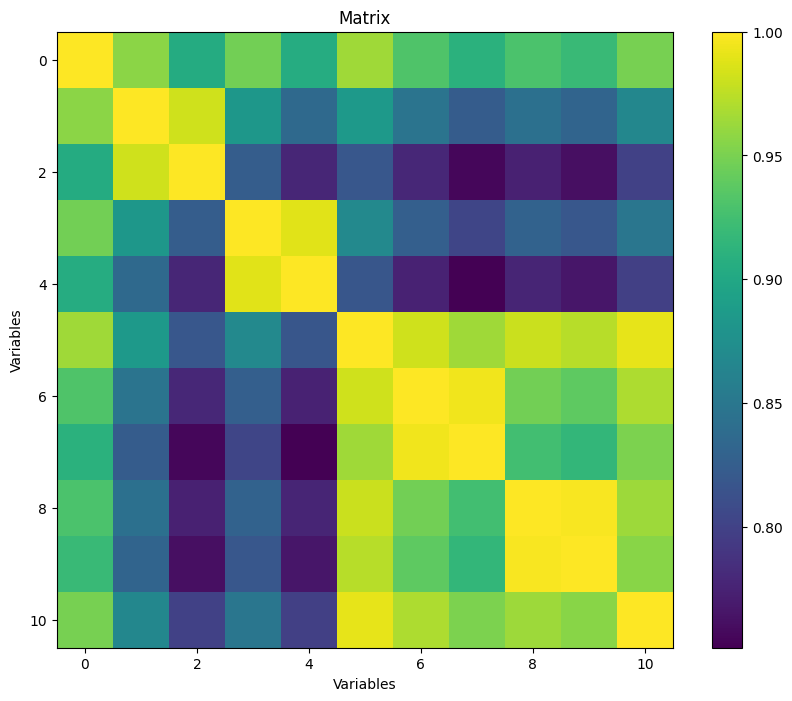

In [8]:
vm_pu_np= vm_pu.to_numpy()
va_degree_np= va_degree.to_numpy()
print(vm_pu_np.shape)
print(va_degree_np.shape)
cov_vv = np.corrcoef(vm_pu_np, rowvar=False)
cov_aa = np.corrcoef(va_degree_np, rowvar=False)
plot_matrix((cov_aa)[1: -1, 1: -1])

12
Nodes: [10, 11, 9, 8, 13, 12, 7, 5, 6, 3, 4, 2]
Edges: [(10, 11), (10, 13), (10, 7), (9, 8), (8, 7), (12, 7), (7, 2), (5, 6), (5, 2), (3, 4), (3, 2)]


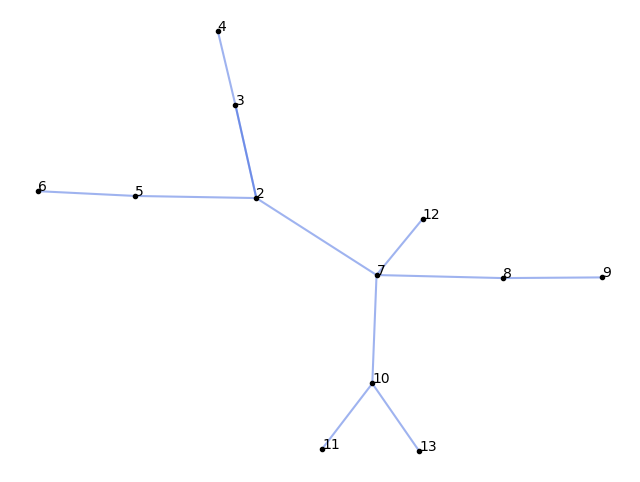

In [9]:
import networkx as nx
import lib.plotGraph as plotGraph

def create_graph_from_matrix(matrix, num_edges):
    # Create a new graph
    G = nx.Graph()
    
    # Get the number of nodes
    n = matrix.shape[0]
    print(n)
    
    # Flatten the matrix to a list of (value, (i, j)) tuples
    edges = [(i, j, matrix[i, j]) for i in range(n) for j in range(n) if i != j]
    
    
    # Sort the list of edges based on weights in descending order
    edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)
    
    # Counter for added edges
    added_edges = 0

    # Iterate over sorted edge list and add to graph if no cycle is formed
    for i, j, weight in edges_sorted:
        # Add edge temporarily
        if not (j+2, i+2) in G.edges():
            G.add_edge(i+2, j+2)
            # Check if a cycle is formed
            if nx.cycle_basis(G) == []:
                added_edges += 1
                # Stop if we have added the desired number of edges
                if added_edges == num_edges:
                    break
            else:
                # Remove edge if it forms a cycle
                G.remove_edge(i+2, j+2)
    
    return G

graph = create_graph_from_matrix((cov_aa-np.eye(13))[1: , 1: ], 11)

# You can print or plot the graph to see the result
print("Nodes:", graph.nodes())
print("Edges:", graph.edges())
plotGraph.plot_spring_layout(graph, label= True)